
# Análise da Rede de Resíduos de Aminoácidos da Proteína 1TUP

Este notebook se dedica à análise do grafo de resíduos de aminoácidos da proteína 1TUP. Esse estudo é feito a partir de algumas medidas de centralidade para os nós da rede e da distribuição dos graus. As análises são baseadas em [material didático](https://github.com/ivanovitchm/datastructure/blob/main/lessons/week13/) do Professor Ivanovitch Silva, da UFRN.




## Import

In [1]:
# Main imports
import pandas as pd              # For data manipulation and reading tabular files
import networkx as nx            # For building and analyzing graphs
import matplotlib.pyplot as plt  # For plotting graphs
import numpy as np               # For numerical operations
import seaborn as sns            # For data visualization
import statistics                # For statistics

# Optional configurations
%matplotlib inline
plt.style.use("ggplot")       # Sets the plot style to 'ggplot' for better aesthetics

## Data Ingestion

In [2]:
# Paths to the input files
nodes_file = "1TUP_nodes2.txt"
edges_file = "1TUP_edges2.txt"

# Load data into DataFrames
df_nodes = pd.read_csv(nodes_file, sep="\t")  # Reads the node table using tab as separator
df_edges = pd.read_csv(edges_file, sep="\t")  # Reads the edge table using tab as separator

# Preview the node data
print("Nodes:")
display(df_nodes.head())  # Shows the first few rows of the node DataFrame

# Preview the edge data
print("Edges:")
display(df_edges.head())  # Shows the first few rows of the edge DataFrame

Nodes:


,NodeId,Chain,Position,Residue,Type,Dssp,Degree,Bfactor_CA,x,y,z,pdbFileName,Model
0,A:94:_:SER,A,94,SER,RES,,5,24.59,75.562,21.797,80.653,input_file.cif#94.A,1
1,A:95:_:SER,A,95,SER,RES,,2,23.53,74.668,19.703,77.670,input_file.cif#95.A,1
2,A:96:_:SER,A,96,SER,RES,,0,26.68,77.257,20.526,75.012,input_file.cif#96.A,1
3,A:97:_:VAL,A,97,VAL,RES,,1,23.40,76.057,22.298,71.922,input_file.cif#97.A,1
4,A:98:_:PRO,A,98,PRO,RES,,0,26.98,77.726,23.380,68.682,input_file.cif#98.A,1


Edges:


,NodeId1,Interaction,NodeId2,Distance,Angle,Atom1,Atom2,Donor,Positive,Cation,Orientation,Model
0,A:94:_:SER,VDW:SC_MC,B:138:_:ALA,3.212,NaN,CB,O,NaN,NaN,NaN,NaN,1
1,A:94:_:SER,HBOND:MC_SC,B:140:_:THR,2.938,119.604,N,OG1,A:94:_:SER,NaN,NaN,NaN,1
2,A:94:_:SER,HBOND:SC_MC,B:140:_:THR,3.180,127.813,OG,N,B:140:_:THR,NaN,NaN,NaN,1
3,A:94:_:SER,VDW:MC_SC,B:140:_:THR,2.756,NaN,N,HG1,NaN,NaN,NaN,NaN,1
4,A:94:_:SER,VDW:SC_SC,B:198:_:GLU,2.388,NaN,H,HE2,NaN,NaN,NaN,NaN,1


## Network Generation

In [3]:
# Initialize the Graph
G = nx.Graph()

# Add all nodes with their attributes
for _, row in df_nodes.iterrows():
    node_id = row["NodeId"]                      # Extract the node identifier
    attributes = row.drop("NodeId").to_dict()    # Convert the remaining columns to a dictionary of attributes
    G.add_node(node_id, **attributes)            # Add the node and its attributes to the graph

print(f"Graph created with {G.number_of_nodes()} nodes.")

Graph created with 630 nodes.


In [4]:
# Adds all columns as edge attributes, allowing multiple edges between the same pair of nodes
for _, row in df_edges.iterrows():
    source = row["NodeId1"]                  # Source node identifier
    target = row["NodeId2"]                  # Target node identifier
    attributes = row.drop(["NodeId1", "NodeId2"]).to_dict()  # All remaining columns become edge attributes

    # Safe conversion of numeric values (e.g., distance, angle, etc.)
    for key in attributes:
        val = attributes[key]
        if pd.isna(val) or val == "nan":     # Handle missing or non-numeric values
            attributes[key] = None
        else:
            try:
                attributes[key] = float(val)  # Convert strings to float when possible
            except (ValueError, TypeError):
                pass  # Leave as string if conversion fails

    # Add the edge with its full set of attributes
    # Since we are using MultiDiGraph, multiple edges between the same nodes are allowed and preserved
    G.add_edge(source, target, **attributes)

print(f"Graph created with {G.number_of_edges()} edges (multiple interactions per node pair allowed).")

Graph created with 671 edges (multiple interactions per node pair allowed).


## Add Betweeness, Closeness and Eigenvalue Centrality values

In [5]:
# Add the closeness centrality, betweenness centrality, eigemvalu centrality
# and core information as attributes
closeness_centrality = nx.closeness_centrality(G, distance='Distance')
betweenness_centrality = nx.betweenness_centrality(G, weight='Distance')
eigenvector_centrality = nx.eigenvector_centrality(G, weight='Distance', max_iter=1000)
core = nx.core_number(G)
nx.set_node_attributes(G, closeness_centrality, "closeness_centrality")
nx.set_node_attributes(G, betweenness_centrality, "betweenness_centrality")
nx.set_node_attributes(G, eigenvector_centrality, "eigenvector_centrality")
nx.set_node_attributes(G, core, "core")

## Export the Network

In [6]:
def sanitize_attributes(G2):
    # Fix node attributes: replace None or NaN values with empty strings
    for node, attrs in G2.nodes(data=True):
        for k, v in attrs.items():
            if v is None or (isinstance(v, float) and pd.isna(v)):
                G2.nodes[node][k] = ""

    # Fix edge attributes: replace None or NaN values with empty strings
    for u, v, attrs in G2.edges(data=True):
        for k, v_attr in attrs.items():
            if v_attr is None or (isinstance(v_attr, float) and pd.isna(v_attr)):
                G2.edges[u, v][k] = ""

In [7]:
# Apply attribute sanitization to make the graph exportable to GEXF format
sanitize_attributes(G)

# Export the graph to a GEXF file, which can be opened in Gephi or reloaded in Python
nx.write_gexf(G, "final_network.gexf")
print("Export completed successfully.")

Export completed successfully.


## Data Visualization

In [8]:
degree_sequence = sorted([d for n, d in G.degree()], reverse=True)

In [9]:
# Mode
degree_sequence_mode = statistics.mode(degree_sequence)
print(f"Mode: {degree_sequence_mode}")

# Mean
degree_sequence_mean = statistics.mean(degree_sequence)
print(f"Mean: {degree_sequence_mean}")

# Median
degree_sequence_median = statistics.median(degree_sequence)
print(f"Median: {degree_sequence_median}")

# Standard deviation
degree_sequence_std = statistics.stdev(degree_sequence)
print(f"Standard deviation: {degree_sequence_std}")

# Mean minus one standard deviation
degree_sequence_mean_minus_one_std = degree_sequence_mean - degree_sequence_std
print(f"Mean minus one standard deviation: {degree_sequence_mean_minus_one_std}")

# Mean plus one standard deviation
degree_sequence_mean_plus_one_std = degree_sequence_mean + degree_sequence_std
print(f"Mean plus one standard deviation: {degree_sequence_mean_plus_one_std}")

# Mean plus two standard deviations
degree_sequence_mean_plus_two_std = degree_sequence_mean + 2*degree_sequence_std
print(f"Mean plus two standard deviations: {degree_sequence_mean_plus_two_std}")

Mode: 1
Mean: 2.13015873015873
Median: 2.0
Standard deviation: 1.548026583191857
Mean minus one standard deviation: 0.5821321469668732
Mean plus one standard deviation: 3.6781853133505873
Mean plus two standard deviations: 5.226211896542444


In [10]:
# List of nodes with degree equal to the mode
degree_sequence_mode_nodes = [n for n, d in G.degree() if d == degree_sequence_mode]

# Number of nodes with degree equal to the mode
print(f"Number of nodes with degree equal to the mode: {len(degree_sequence_mode_nodes)}")

Number of nodes with degree equal to the mode: 171


In [11]:
# Nodes with degree equal to the mode
print(f"Nodes with degree equal to the mode:")
degree_sequence_mode_nodes

Nodes with degree equal to the mode:


['A:95:_:SER',
 'A:97:_:VAL',
 'A:101:_:LYS',
 'A:104:_:GLN',
 'A:105:_:GLY',
 'A:108:_:GLY',
 'A:116:_:SER',
 'A:118:_:THR',
 'A:119:_:ALA',
 'A:122:_:VAL',
 'A:123:_:THR',
 'A:128:_:PRO',
 'A:130:_:LEU',
 'A:138:_:ALA',
 'A:139:_:LYS',
 'A:142:_:PRO',
 'A:147:_:VAL',
 'A:149:_:SER',
 'A:154:_:GLY',
 'A:160:_:MET',
 'A:166:_:SER',
 'A:167:_:GLN',
 'A:170:_:THR',
 'A:172:_:VAL',
 'A:177:_:PRO',
 'A:181:_:ARG',
 'A:182:_:CYS',
 'A:186:_:ASP',
 'A:191:_:PRO',
 'A:192:_:GLN',
 'A:195:_:ILE',
 'A:200:_:ASN',
 'A:202:_:ARG',
 'A:203:_:VAL',
 'A:207:_:ASP',
 'A:210:_:ASN',
 'A:211:_:THR',
 'A:214:_:HIS',
 'A:219:_:PRO',
 'A:223:_:PRO',
 'A:227:_:SER',
 'A:232:_:ILE',
 'A:235:_:ASN',
 'A:239:_:ASN',
 'A:244:_:GLY',
 'A:247:_:ASN',
 'A:248:_:ARG',
 'A:250:_:PRO',
 'A:256:_:THR',
 'A:260:_:SER',
 'A:262:_:GLY',
 'A:263:_:ASN',
 'A:264:_:LEU',
 'A:266:_:GLY',
 'A:269:_:SER',
 'A:275:_:CYS',
 'A:277:_:CYS',
 'A:279:_:GLY',
 'A:280:_:ARG',
 'A:289:_:LEU',
 'B:98:_:PRO',
 'B:100:_:GLN',
 'B:104:_:G

In [12]:
# List of nodes with degree over mean plus two standard deviations
degree_sequence_tail = [n for n, d in G.degree() if d > degree_sequence_mean_plus_two_std]

# Number of nodes at tail
print(f"Number of nodes at tail: {len(degree_sequence_tail)}")

Number of nodes at tail: 10


In [13]:
# Nodes at tail
print(f"Nodes at tail:")
degree_sequence_tail

Nodes at tail:


['A:163:_:TYR',
 'A:171:_:GLU',
 'A:175:_:ARG',
 'A:176:_:CYS',
 'B:236:_:TYR',
 'C:175:_:ARG',
 'C:242:_:CYS',
 'C:273:_:ARG',
 'E:1013:_:DG',
 'E:1014:_:DC']

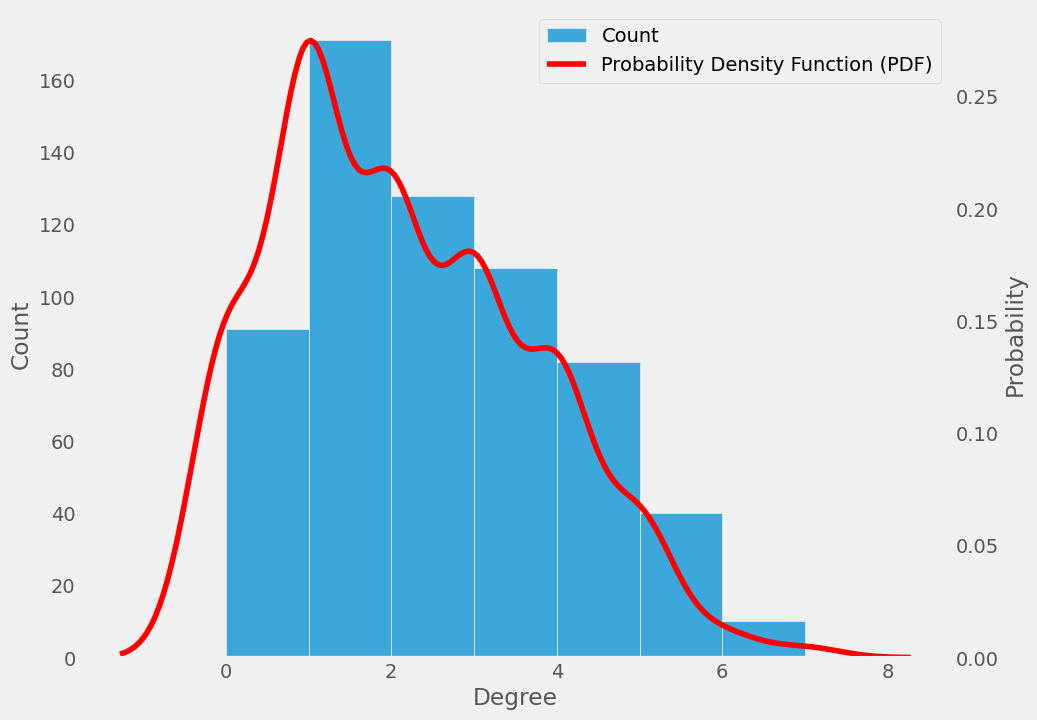

In [14]:
plt.style.use("fivethirtyeight")
#plt.style.use("default")

fig, ax = plt.subplots(1,1,figsize=(10,8))

sns.histplot(degree_sequence,bins=7,label="Count",ax=ax)
ax2 = ax.twinx()
sns.kdeplot(degree_sequence,color='r',label="Probability Density Function (PDF)",ax=ax2)

# ask matplotlib for the plotted objects and their labels
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)

ax.grid(False)
ax2.grid(False)
ax.set_xlabel("Degree")
ax2.set_ylabel("Probability")

plt.savefig('probability_density_function.png', transparent=True,dpi=600,bbox_inches="tight")
plt.show()

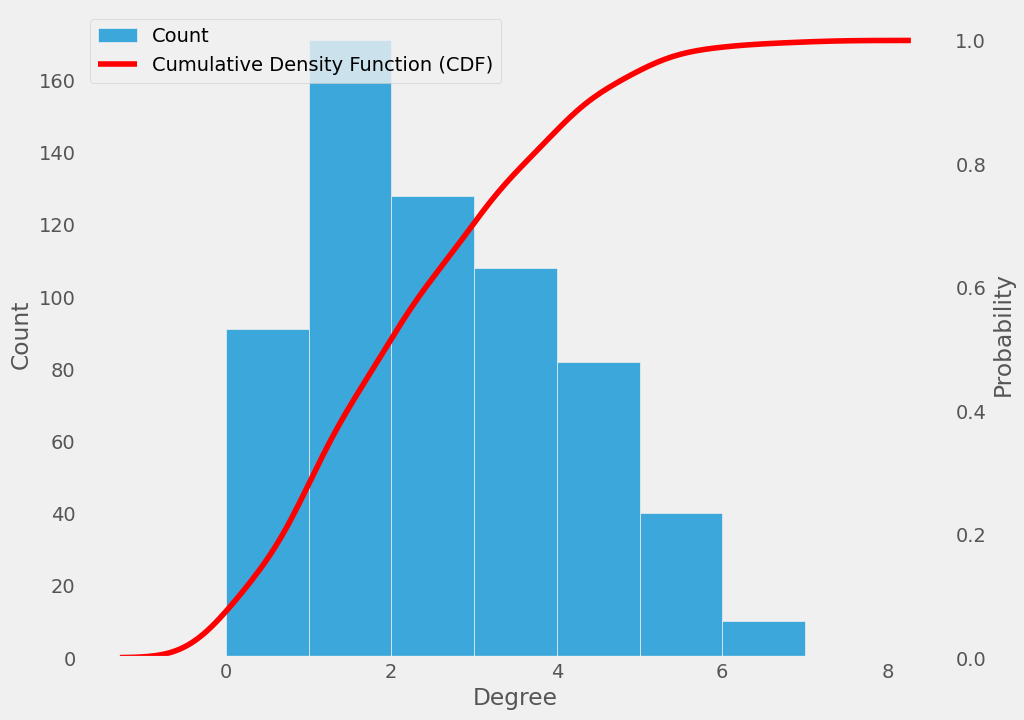

In [15]:
plt.style.use("fivethirtyeight")
#plt.style.use("default")

fig, ax = plt.subplots(1,1,figsize=(10,8))

sns.histplot(degree_sequence,bins=7,label="Count",ax=ax)
ax2 = ax.twinx()
sns.kdeplot(degree_sequence,color='r',label="Cumulative Density Function (CDF)",ax=ax2,cumulative=True)

# ask matplotlib for the plotted objects and their labels
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)

ax.grid(False)
ax2.grid(False)
ax.set_xlabel("Degree")
ax2.set_ylabel("Probability")

plt.savefig('cumulative_density_function.png', transparent=True,dpi=600,bbox_inches="tight")
plt.show()

In [16]:
# Get the degree values at 25%, 50%, and 75% of the CDF
degree_25_percentile = np.percentile(degree_sequence, 25)
degree_50_percentile = np.percentile(degree_sequence, 50)
degree_75_percentile = np.percentile(degree_sequence, 75)

print(f"Degree at 25% of CDF: {degree_25_percentile}")
print(f"Degree at 50% of CDF (Median): {degree_50_percentile}")
print(f"Degree at 75% of CDF: {degree_75_percentile}")


Degree at 25% of CDF: 1.0
Degree at 50% of CDF (Median): 2.0
Degree at 75% of CDF: 3.0


In [17]:
# Calculate the number of elements with degree less than or equal to 1
count_le_one = sum(1 for degree in degree_sequence if degree <= 1)

# Calculate the number of elements with degree less than or equal to 1
count_le_two = sum(1 for degree in degree_sequence if degree <= 2)

# Calculate the number of elements with degree less than or equal to 1
count_le_three = sum(1 for degree in degree_sequence if degree <= 3)

# Calculate the total number of elements in degree_sequence
total_elements = len(degree_sequence)

# Calculate the percentage
percentage_le_one = (count_le_one / total_elements) * 100
percentage_le_two = (count_le_two / total_elements) * 100
percentage_le_three = (count_le_three / total_elements) * 100

print(f"Percentage of nodes with degree <= 1: {percentage_le_one:.2f}%")
print(f"Percentage of nodes with degree <= 2: {percentage_le_two:.2f}%")
print(f"Percentage of nodes with degree <= 3: {percentage_le_three:.2f}%")

Percentage of nodes with degree <= 1: 41.59%
Percentage of nodes with degree <= 2: 61.90%
Percentage of nodes with degree <= 3: 79.05%


In [18]:
bc = pd.Series(nx.betweenness_centrality(G))
dc = pd.Series(nx.degree_centrality(G))
ec = pd.Series(nx.eigenvector_centrality(G))
cc = pd.Series(nx.closeness_centrality(G))

df = pd.DataFrame.from_dict({"Betweenness": bc,
                            "Degree": dc,
                            "EigenVector": ec,
                            "Closeness": cc})
df.reset_index(inplace=True,drop=True)
df.head()

,Betweenness,Degree,EigenVector,Closeness
0,0.011161,0.004769,6.059786e-04,0.052587
1,0.000000,0.001590,5.169352e-04,0.052399
2,0.000000,0.000000,3.508845e-57,0.000000
3,0.000000,0.001590,1.365328e-03,0.049687
4,0.000000,0.000000,3.508845e-57,0.000000


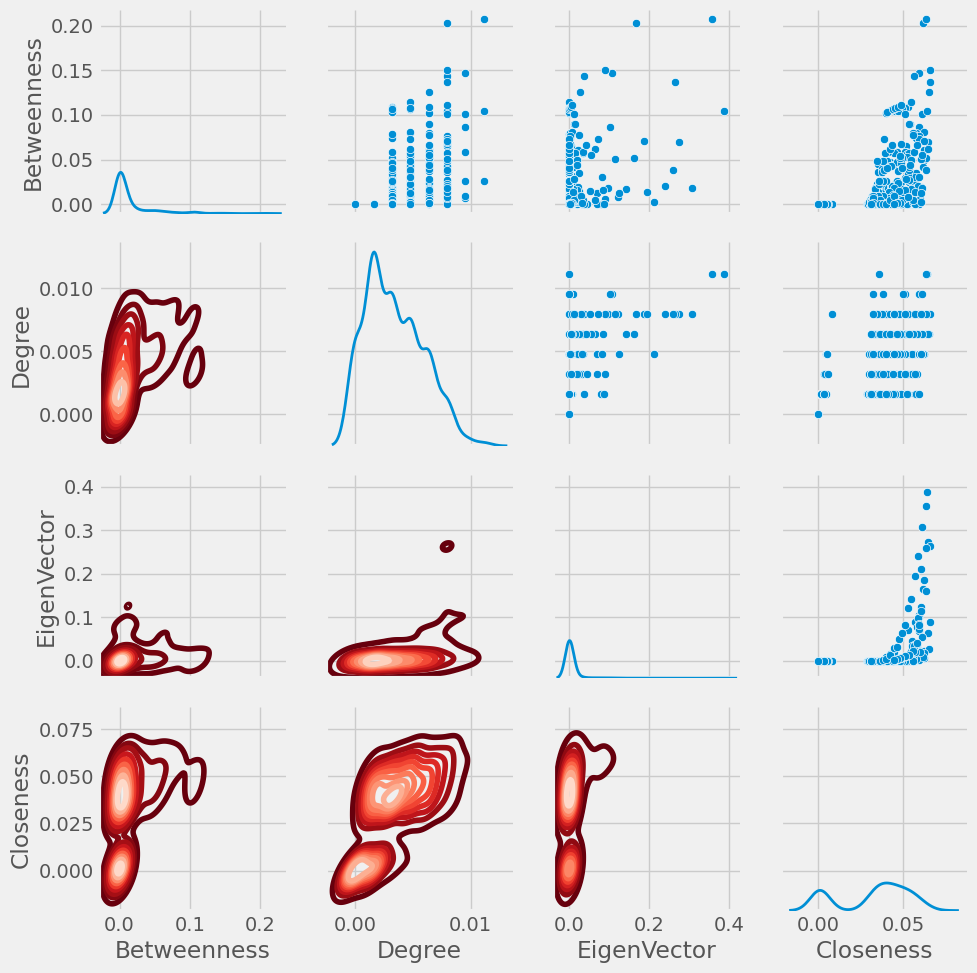

In [19]:
fig = sns.PairGrid(df)
fig.map_upper(sns.scatterplot)
fig.map_lower(sns.kdeplot, cmap="Reds_r")
fig.map_diag(sns.kdeplot, lw=2, legend=False)

plt.savefig('all.png', transparent=True,dpi=800,bbox_inches="tight")
plt.show()